# 决策树

决策树是一种机器学习的方法。决策树是一种树形结构，其中每个内部节点表示一个属性上的判断，每个分支代表一个判断结果的输出，最后每个叶节点代表一种分类结果。决策树的关键在于如何选择特征，分类一般都是信息增益原理（最小熵或者最小Gini），回归则常使用方差。

* 根节点：包含样本的全集
* 内部节点：对应特征属性测试
* 叶节点：代表决策的结果

![overview](./images/overview.png)

## 熵

![gini](./images/gini.png)

在做特征选择时，当选择了一个特征进行分叉之后，我们发现熵减小了，也就是这个特征有信息增益，那么就可以选择这个特征。当然，应该优中选优。

![information-enhance](./images/gini-information.png)

## 不同的信息增益算法

![algorithm](./images/algorithm.png)

## 剪枝

决策树非常容易过拟合，当决策树足够大时，每个叶子结点就一个数据，这时候熵肯定是最小的，但也会过拟合。这时候就需要剪枝，分为：

* 预剪枝：构建树的同时剪枝，比较实用。通过限制深度，叶子节点个数，叶子结点样本数，信息增益量等
* 后剪枝：建立完决策树之后进行剪枝操作。通过设置一定衡量标准（类似损失函数），比如叶子结点越多，损失越大。

In [16]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from math import log
import operator

def createTree(dataset, labels, featLabels):
	classList = [example[-1] for example in dataset]
	if classList.count(classList[0]) == len(classList):
		return classList[0]
	if len(dataset[0]) == 1:
		return majorityCnt(classList)
	bestFeat = chooseBestFeatureToSplit(dataset)
	bestFeatLabel = labels[bestFeat]
	featLabels.append(bestFeatLabel)
	myTree = {bestFeatLabel: {}}
	del labels[bestFeat]
	featValue = [example[bestFeat] for example in dataset]
	uniqueVals = set(featValue)
	for value in uniqueVals:
		sublabels = labels[:]
		myTree[bestFeatLabel][value] = createTree(splitDataSet(
		    dataset, bestFeat, value), sublabels, featLabels)
	return myTree


def majorityCnt(classList):
	classCount = {}
	for vote in classList:
		if vote not in classCount.keys(): classCount[vote] = 0
		classCount[vote] += 1
	sortedclassCount = sorted(
	    classCount.items(), key=operator.itemgetter(1), reverse=True)
	return sortedclassCount[0][0]


def chooseBestFeatureToSplit(dataset):
	numFeatures = len(dataset[0]) - 1
	baseEntropy = calcShannonEnt(dataset)
	bestInfoGain = 0
	bestFeature = -1
	for i in range(numFeatures):
		featList = [example[i] for example in dataset]
		uniqueVals = set(featList)
		newEntropy = 0
		for val in uniqueVals:
			subDataSet = splitDataSet(dataset, i, val)
			prob = len(subDataSet)/float(len(dataset))
			newEntropy += prob * calcShannonEnt(subDataSet)
		infoGain = baseEntropy - newEntropy
		if (infoGain > bestInfoGain):
			bestInfoGain = infoGain
			bestFeature = i
	return bestFeature


def splitDataSet(dataset, axis, val):
	retDataSet = []
	for featVec in dataset:
		if featVec[axis] == val:
			reducedFeatVec = featVec[:axis]
			reducedFeatVec.extend(featVec[axis+1:])
			retDataSet.append(reducedFeatVec)
	return retDataSet


def calcShannonEnt(dataset):
	numexamples = len(dataset)
	labelCounts = {}
	for featVec in dataset:
		currentlabel = featVec[-1]
		if currentlabel not in labelCounts.keys():
			labelCounts[currentlabel] = 0
		labelCounts[currentlabel] += 1

	shannonEnt = 0
	for key in labelCounts:
		prop = float(labelCounts[key])/numexamples
		shannonEnt -= prop*log(prop, 2)
	return shannonEnt

def getNumLeafs(myTree):
	numLeafs = 0												
	firstStr = next(iter(myTree))								
	secondDict = myTree[firstStr]								
	for key in secondDict.keys():
	    if type(secondDict[key]).__name__=='dict':				
	        numLeafs += getNumLeafs(secondDict[key])
	    else:   numLeafs +=1
	return numLeafs


def getTreeDepth(myTree):
	maxDepth = 0												
	firstStr = next(iter(myTree))								
	secondDict = myTree[firstStr]								
	for key in secondDict.keys():
	    if type(secondDict[key]).__name__=='dict':				
	        thisDepth = 1 + getTreeDepth(secondDict[key])
	    else:   thisDepth = 1
	    if thisDepth > maxDepth: maxDepth = thisDepth			
	return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
	arrow_args = dict(arrowstyle="<-")											
	font = FontProperties(fname=r"c:\windows\fonts\simsunb.ttf", size=14)		
	createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',	
		xytext=centerPt, textcoords='axes fraction',
		va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)


def plotMidText(cntrPt, parentPt, txtString):
	xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]																
	yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
	createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)


def plotTree(myTree, parentPt, nodeTxt):
	decisionNode = dict(boxstyle="sawtooth", fc="0.8")										
	leafNode = dict(boxstyle="round4", fc="0.8")											
	numLeafs = getNumLeafs(myTree)  														
	depth = getTreeDepth(myTree)															
	firstStr = next(iter(myTree))																								
	cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)	
	plotMidText(cntrPt, parentPt, nodeTxt)													
	plotNode(firstStr, cntrPt, parentPt, decisionNode)										
	secondDict = myTree[firstStr]															
	plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD										
	for key in secondDict.keys():								
		if type(secondDict[key]).__name__=='dict':											
			plotTree(secondDict[key],cntrPt,str(key))        								
		else:																														
			plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
			plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
			plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
	plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD


def createPlot(inTree):
	fig = plt.figure(1, facecolor='white')													#创建fig
	fig.clf()																				#清空fig
	axprops = dict(xticks=[], yticks=[])
	createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    							#去掉x、y轴
	plotTree.totalW = float(getNumLeafs(inTree))											#获取决策树叶结点数目
	plotTree.totalD = float(getTreeDepth(inTree))											#获取决策树层数
	plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;								#x偏移
	plotTree(inTree, (0.5,1.0), '')															#绘制决策树
	plt.show()

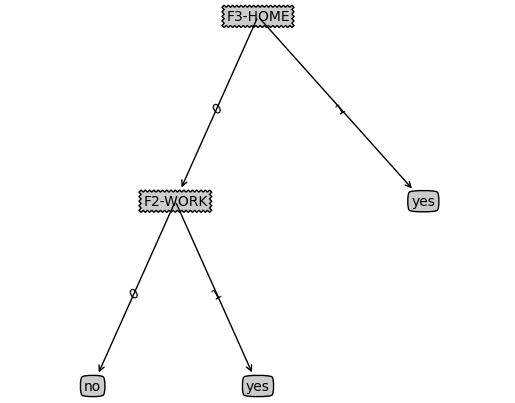

In [17]:
def createDataSet():
	dataSet = [[0, 0, 0, 0, 'no'],
			[0, 0, 0, 1, 'no'],
			[0, 1, 0, 1, 'yes'],
			[0, 1, 1, 0, 'yes'],
			[0, 0, 0, 0, 'no'],
			[1, 0, 0, 0, 'no'],
			[1, 0, 0, 1, 'no'],
			[1, 1, 1, 1, 'yes'],
			[1, 0, 1, 2, 'yes'],
			[1, 0, 1, 2, 'yes'],
			[2, 0, 1, 2, 'yes'],
			[2, 0, 1, 1, 'yes'],
			[2, 1, 0, 1, 'yes'],
			[2, 1, 0, 2, 'yes'],
			[2, 0, 0, 0, 'no']]
	labels = ['F1-AGE', 'F2-WORK', 'F3-HOME', 'F4-LOAN']
	return dataSet, labels
    
dataset, labels = createDataSet()
featLabels = []
myTree = createTree(dataset, labels, featLabels)
createPlot(myTree)
